<a href="https://colab.research.google.com/github/Lemon-Aki/DeepLearningFromScratch1/blob/main/Chapter4-1~4-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#신경망 학습 : 훈련 데이터로부터 가중치 매개변수의 최적겂을 자동으로 획득하는 것
#손실함수 : 손실 함수의 결과값을 가장 작게 만드는 가중치 매개변수를 찾는것이 학습의 목표, 일반적으로 평균 제곱 오차, 교차 엔트로피 오차 사용
#특징(feature) : 입력 데이터에서 본질적인 데이터를 정확하게 추출할 수 있도록 설계 된 변환기, 
#이미지의 특징은 보통 벡터로 기술, 컴퓨터 비전 분야에는 SIFT, SURF, HOG 등 특징을 많이 사용
#딥러닝(신경망) : 종단간 기계학습, 사람의 개입 없이 처음부터 끝까지 이미지에 포함된 특징을 기계가 스스로 학습 함
#훈련 데이터와 신경데이터를 나누는 이유 : 범용 능력을 평가하기 위해, 훈련 데이터에 과대적합(오버피팅)되는 것을 방지하기 위해


In [2]:
#평균제곱 오차 : 오차가 더 작은 쪽이 정답에 더 가까움
import numpy as np

def mean_squared_error(y, t):
  return 0.5 * np.sum((y-t)**2)

t = [0,0,1,0,0,0,0,0,0,0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))
print(mean_squared_error(np.array(y2), np.array(t)))

0.09750000000000003
0.5975


In [3]:
#교차 엔트로피 오차 : 정답에 해당하는 인덱스의 원소만 1이고 나머지는 0이기 때문에 정답일 때의 출력이 전체 값을 결정
#결과(오차값)가 더 작은 쪽이 정답에 더 가까움
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta)) #np.log()내부가 0이되면 마이너스 무한대(-inf)가 되기 때문에 아주 작은 값을 추가

print(cross_entropy_error(np.array(y), np.array(t)))
print(cross_entropy_error(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


In [4]:
# 코랩과 구글드라이드를 연동(인증 필요)
#Transport endpoint is not connected 에러시 코랩 재연결
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/DeepLearningFromScratch1/

Mounted at /gdrive
/gdrive/MyDrive/DeepLearningFromScratch1


In [5]:
#미니배치 학습: 훈련데이터가 너무 많을경우, 일부를 추려 전체의 근사치로 이용하는 학습방법
#import sys, os
#sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_text) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

def cross_entropy_error2(y, t):
  #y배열이 1차원일경우 2차원으로 변형
  if y.ndim == 1:
    t = t.reshape(1, t.size) # 1-D 로 변환, t.size는 t의 요소 갯수를 의미
    y = y.reshape(1, y.size) # 1-D 로 변환

  print(t.shape)
  print(y.shape)

  batch_size = y.shape[0]
  #return -np.sum(t * np.log(y + 1e-7)) / batch_size   # 원핫인코딩일 경우 t가 0일때는 교차 엔트로피 오차도 0이므로 무시해도 좋다는 것이 핵심
  #return -np.sum( np.log( y[np.arange(batch_size), t] )) / batch_size   # 원핫인코딩이 아닐경우

print(cross_entropy_error2(x_batch, t_batch))

(60000, 784)
(60000, 10)
(10, 10)
(10, 784)
None


In [6]:
#손실 함수를 사용하는 이유
#신경망 학습에서 최적의 매개변수(가중치와 편향)를 탐색할 때 손실 함수의 값을 가능한 한 작게 하는 매개변수를 찾음
#이때, 매개변수의 미분(기울기)를 계산하고, 그 미분 값을 단서로 매개변수의 값을 갱신하는 과정을 반복
#정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 대문에 정확도를 사용하지 않음
#시그모이드 함수의 미분은 어느 장소라도 0이 되지 않기 때문에 신경망이 올바르게 학습 가능
#미분 나쁜 예
#반올림 오차(작은 값이 생략되어 최종 계산 결과에 오차가 생김), h를 무한이 0으로 좁히는 것이 불가능한 오차
def numerical_diff(f, x):
  h = 10e-50
  return(f(x + h) - f(x)) / h

In [7]:
#개선된 미분
def numerical_diff2(f, x):
  h = 1e-4 #0.0001
  return (f(x+h) - f(x-h)) / (2*h)

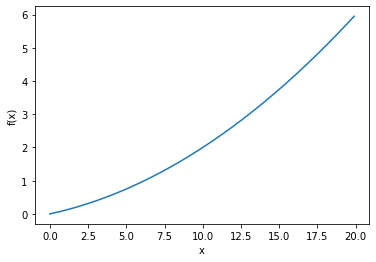

In [8]:
#2차함수 그리기
def function_1(x):
  return 0.01*x**2 + 0.1*x

import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [9]:
#미분 값 출력
print(numerical_diff2(function_1, 5))
print(numerical_diff2(function_1, 10))

0.1999999999990898
0.2999999999986347


0.1999999999990898


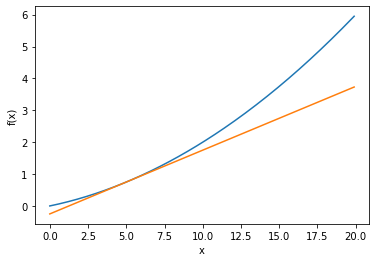

In [10]:
#미분 값을 기울기로 하는 직선 그리기
def tangent_line(f, x):           # 접선의 함수를 반환하는 함수
    d = numerical_diff2(f, x)        # 수치미분값 ( 접선의 기울기 의미)
    print(d)
    y = f(x) - d*x                  # 접선의 절편
    return lambda t: d*t + y      # 접선의 함수 t 반환
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)    # x = 5 일 때 접선의 함수 생성 
y2 = tf(x)                          # x범위 만큼의 접선의 함수 결과값

plt.plot(x, y)                      # 함수 f(x)
plt.plot(x, y2)                     # 접선
plt.show()

In [11]:
#편미분 : 변수가 여러개인 함수에 대한 미분, 목표 변수 하나에 초점을 맞추고 다른 변수는 값을 고정
def function_2(x):
  return x[0]**2 + x[1]**2
  #return np.sum(x**2)

def function_tmp1(x0):
  return x0*x0 + 4.0**2.0

def function_tmp2(x1):
  return 3.0**2.0 + x1*x1


print(numerical_diff2(function_tmp1, 3.0))
print(numerical_diff2(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


In [12]:
#기울기 : 모든 변수의 편미분을 벡터로 정리한 것
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x) #x와 형상이 같고 값이 0인 배열 생성

  for idx in range(x.size):
    tmp_val = x[idx]
    #f(x+h) 계산
    x[idx] = tmp_val + h
    fxh1 = f(x)

    #f(x-h) 계산
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val
  
  return grad

print(numerical_gradient(function_2, np.array([3.0,4.0])))
print(numerical_gradient(function_2, np.array([0.0,2.0])))
print(numerical_gradient(function_2, np.array([3.0,0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


No handles with labels found to put in legend.


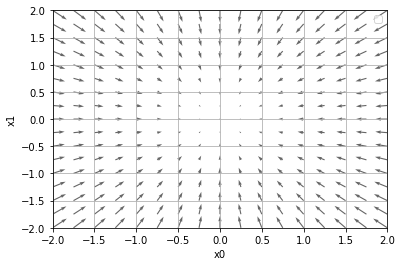

In [13]:
#기울기의 결과에 마이너스를 붙인 벡터 출력
#기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient2(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient2(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient2(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

In [14]:
#경사법 : 현 위치에서 기울어진 방향으로 일정 거리만큼 이동, 기울기를 구하고, 그 방향으로 나아아기를 반복, 보통 경사하강법을 사용
#경사법은 기울기가 0인 장소를 찾지만 반드시 최솟값은 아님, 극솟값, 최솟값, 안장점(보는 방향에따라 극댓값, 극솟값이 되는 점)일수도 있음
#학습률 : 한번의 학습으로 얼마만큼 학습해야 할지, 매개변수 값을 얼마나 갱신할지를 정함
#하이퍼 파라미터 : 학습률 등 사람이 직접 설정해야 하는 매개변수
def gradient_descent(f, init_x, lr=0.01, step_num=100):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f,x)
    x -= lr * grad
  return x

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100))

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100))

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100))

[-6.11110793e-10  8.14814391e-10]
[-2.58983747e+13 -1.29524862e+12]
[-2.99999994  3.99999992]


In [33]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
  def __init__(self):
    self.W = np.random.randn(2,3)

  def predict(self, x):
    return np.dot(x, self.W)

  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y, t)

    return loss

net = simpleNet()
print(net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

print(np.argmax(p))

t=np.array([0,0,1])
net.loss(x, t)

#def f(W):
#  return net.loss(x, t)
f = lambda w: net.loss(x,t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.08695577  1.50773277 -0.70817842]
 [-0.82730801 -0.48317859 -0.90504732]]
[-0.69240374  0.46977894 -1.23944964]
1
[[ 0.12563961  0.4016577  -0.5272973 ]
 [ 0.18845941  0.60248655 -0.79094596]]
